In [1]:
import torch
import pandas as pd
import os
main_dir = '../wind-profiles/updated'
#directories = ['CR1992', 'CR2056', 'CR2071', 'CR2125', 'CR2210']
directories = []
total_size = 640
segment_to_skip = 100

torch.set_default_dtype(torch.float64)
torch.set_printoptions(precision=10)
# three dimensional tensors, with shape (len(dir), 640, 9) and (len(dir), 640, 3)
X_data_train = torch.empty(0, total_size - segment_to_skip, 5)
y_data_train = torch.empty(0, total_size - segment_to_skip, 3)
X_data_test = torch.empty(0, total_size - segment_to_skip, 5)
y_data_test = torch.empty(0, total_size - segment_to_skip, 3)

for directory in directories:
    for file_ in os.listdir(f'{main_dir}/Training_files/{directory}'):
        data = pd.read_csv(f'{main_dir}/Training_files/{directory}/{file_}', delimiter=',', 
                        header=0, names=['R', 'L', 'Lon', 'Lat', 'n', 'v', 'T', 'B', 'A/A0', 'alpha', 'V/Cs', 'propag_dt'], 
                        skiprows=2, dtype=float, na_values=['                      NaN', '                     -NaN'])
        
        # if data has NaN values in R column, continue to next file
        if data[['R', 'L', 'B', 'A/A0', 'alpha', 'n', 'v', 'T']].isnull().values.any():
            continue
        
        # convert to tensor, with shape (len(data), 3), where the three channels are R, B, alpha
        X_sample = torch.tensor(data[['R', 'L', 'B', 'A/A0', 'alpha']].values, dtype=torch.float32)
        y_sample = torch.tensor(data[['n', 'v', 'T']].values, dtype=torch.float32)
        
        X_data_train = torch.cat((X_data_train, X_sample[segment_to_skip:, :].unsqueeze(0)), dim=0)
        y_data_train = torch.cat((y_data_train, y_sample[segment_to_skip:, :].unsqueeze(0)), dim=0)

for directory in directories:
    for file_ in os.listdir(f'{main_dir}/Validation_files/{directory}'):
        data = pd.read_csv(f'{main_dir}/Validation_files/{directory}/{file_}', delimiter=',', 
                        header=0, names=['R', 'L', 'Lon', 'Lat', 'n', 'v', 'T', 'B', 'A/A0', 'alpha', 'V/Cs', 'propag_dt'], 
                        skiprows=2, dtype=float, na_values=['                      NaN', '                     -NaN'])
        
        # if data has NaN values in R column, continue to next file
        if data[['R', 'L', 'B', 'A/A0', 'alpha', 'n', 'v', 'T']].isnull().values.any():
            continue
        
        # convert to tensor, with shape (len(data), 3), where the three channels are R, B, alpha
        X_sample = torch.tensor(data[['R', 'L', 'B', 'A/A0', 'alpha']].values, dtype=torch.float32)
        y_sample = torch.tensor(data[['n', 'v', 'T']].values, dtype=torch.float32)
        
        X_data_test = torch.cat((X_data_test, X_sample[segment_to_skip:, :].unsqueeze(0)), dim=0)
        y_data_test = torch.cat((y_data_test, y_sample[segment_to_skip:, :].unsqueeze(0)), dim=0)


In [8]:
# save tensors to file
# swap last two dimensions
#X_data_train = X_data_train.permute(0, 2, 1)
#y_data_train = y_data_train.permute(0, 2, 1)
#X_data_test = X_data_test.permute(0, 2, 1)
#y_data_test = y_data_test.permute(0, 2, 1)
#torch.save(X_data_train, 'X_data_train.pt')
#torch.save(y_data_train, 'y_data_train.pt')
#torch.save(X_data_test, 'X_data_test.pt')
#torch.save(y_data_test, 'y_data_test.pt')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# load tensors from file
X_train = torch.load('X_data_train.pt').to(torch.float64)
y_train = torch.load('y_data_train.pt').to(torch.float64)
X_test = torch.load('X_data_test.pt').to(torch.float64)
y_test = torch.load('y_data_test.pt').to(torch.float64)

In [4]:
X_train[:, 2, :] = torch.abs(X_train[:, 2, :])
X_test[:, 2, :] = torch.abs(X_test[:, 2, :])
X_train[:, 3, :] = torch.abs(X_train[:, 3, :])
X_test[:, 3, :] = torch.abs(X_test[:, 3, :])

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([10582, 5, 540]),
 torch.Size([10582, 3, 540]),
 torch.Size([1177, 5, 540]),
 torch.Size([1177, 3, 540]))

In [6]:
# train test split
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([9523, 5, 540]),
 torch.Size([1177, 5, 540]),
 torch.Size([9523, 3, 540]),
 torch.Size([1177, 3, 540]))

In [8]:
import torch

class TensorRobustScaler:
    def __init__(self):
        self.median = None
        self.iqr = None

    def fit(self, X):
        X = X.view(-1)
        self.median = torch.quantile(X, 0.5, dim=-1)
        q1 = torch.quantile(X, 0.25, dim=-1)
        q3 = torch.quantile(X, 0.75, dim=-1)
        self.iqr = q3 - q1

    def transform(self, X):
        return (X - self.median) / self.iqr

    def inverse_transform(self, X):
        return (X * self.iqr) + self.median


def get_normalization_info_inputs(X):
    X_normalized = X.clone()
    normalization_info = {}
    
    for var in [0, 1]:
        X_var = X_normalized[:, var, :]
        X_var_transformed = torch.log1p(X_var)
        mean = X_var_transformed.mean()
        std = X_var_transformed.std()
        normalization_info[var] = {"mean": mean, "std": std, "method": "log_standardization"}
    
    for var in [2, 3]:
        tensor_robust_scaler = TensorRobustScaler()
        X_var = X_normalized[:, var, :]
        X_var_transformed = torch.log1p(X_var)
        tensor_robust_scaler.fit(X_var_transformed)
        normalization_info[var] = {"scaler": tensor_robust_scaler, "method": "log_robust_scaling"}
        
    for var in [4]:
        X_var = X_normalized[:, var, :]
        mean = X_var.mean()
        std = X_var.std()
        normalization_info[var] = {"mean": mean, "std": std, "method": "standardization"}
        
    return normalization_info

def get_normalization_info_outputs(y):
    y_normalized = y.clone()
    normalization_info = {}
    
    for var in [0]:
        y_var = y_normalized[:, var, :]
        y_var_transformed = torch.log1p(y_var)
        mean = y_var_transformed.mean()
        std = y_var_transformed.std()
        normalization_info[var] = {"mean": mean, "std": std, "method": "log_standardization"}
        
    for var in [1, 2]:
        y_var = y_normalized[:, var, :]
        mean = y_var.mean()
        std = y_var.std()
        normalization_info[var] = {"mean": mean, "std": std, "method": "standardization"}
    
    return normalization_info

def normalize(X, normalization_info):
    X_normalized = X.clone()
    
    for var, info in normalization_info.items():
        if info["method"] == "standardization":
            mean = info["mean"]
            std = info["std"]
            X_normalized[:, var, :] = (X_normalized[:, var, :] - mean) / std
        if info["method"] == "log_standardization":
            mean = info["mean"]
            std = info["std"]
            X_normalized[:, var, :] = (torch.log1p(X_normalized[:, var, :]) - mean) / std
        elif info["method"] == "log_robust_scaling":
            scaler = info["scaler"]
            X_normalized[:, var, :] = scaler.transform(torch.log1p(X_normalized[:, var, :]))
    
    return X_normalized

def denormalize(X_normalized, normalization_info):
    X_denormalized = X_normalized.clone()
    
    for var, info in normalization_info.items():
        if info["method"] == "standardization":
            mean = info["mean"]
            std = info["std"]
            X_denormalized[:, var, :] = (X_denormalized[:, var, :] * std) + mean
        if info["method"] == "log_standardization":
            mean = info["mean"]
            std = info["std"]
            X_denormalized[:, var, :] = torch.expm1((X_denormalized[:, var, :] * std) + mean)
        elif info["method"] == "log_robust_scaling":
            scaler = info["scaler"]
            X_denormalized[:, var, :] = torch.expm1(scaler.inverse_transform(X_denormalized[:, var, :]))
    
    return X_denormalized

In [9]:
X_normalization_info = get_normalization_info_inputs(X_train)
y_normalization_info = get_normalization_info_outputs(y_train)

In [10]:
X_normalization_info

{0: {'mean': tensor(1.3850400145),
  'std': tensor(0.8841279412),
  'method': 'log_standardization'},
 1: {'mean': tensor(1.3966905142),
  'std': tensor(0.8855448329),
  'method': 'log_standardization'},
 2: {'scaler': <__main__.TensorRobustScaler at 0x12d14d50950>,
  'method': 'log_robust_scaling'},
 3: {'scaler': <__main__.TensorRobustScaler at 0x12d2f3c1550>,
  'method': 'log_robust_scaling'},
 4: {'mean': tensor(2.2325432011),
  'std': tensor(15.9544379715),
  'method': 'standardization'}}

In [11]:
X_train_normalized = normalize(X_train, X_normalization_info)
X_val_normalized = normalize(X_val, X_normalization_info)
X_test_normalized = normalize(X_test, X_normalization_info)

y_train_normalized = normalize(y_train, y_normalization_info)
y_val_normalized = normalize(y_val, y_normalization_info)
y_test_normalized = normalize(y_test, y_normalization_info)

In [12]:
X_train_normalized.max(), X_train_normalized.min(), y_train_normalized.max(), y_train_normalized.min()

(tensor(5.4545885987),
 tensor(-5.5025389428),
 tensor(4.1129185968),
 tensor(-3.0945715485))

In [13]:
import torch.nn as nn
import torch.optim as optim

# Model parameters
sequence_length = total_size - segment_to_skip
input_channels = 5
output_channels = 3
batch_size = 128

In [14]:
# create me a simple 1D convolutional network
class SimpleFeedForward(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(SimpleFeedForward, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(input_channels * sequence_length, 2056)
        self.batchnorm1 = nn.BatchNorm1d(2056)
        self.dropout1 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(2056, 1024)
        self.batchnorm2 = nn.BatchNorm1d(1024)
        self.dropout2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(1024, 1024)
        self.batchnorm3 = nn.BatchNorm1d(1024)
        self.dropout3 = nn.Dropout(p=0.1)
        self.fc4 = nn.Linear(1024, 2056)
        self.batchnorm4 = nn.BatchNorm1d(2056)
        self.dropout4 = nn.Dropout(p=0.1)
        self.fc5 = nn.Linear(2056, output_channels * sequence_length)

        # Do xavier initialization
        layers = [self.fc1, self.fc2, self.fc3, self.fc4, self.fc5]
        for layer in layers:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.reshape(batch_size, -1)

        x = self.dropout1(self.relu(self.batchnorm1(self.fc1(x))))
        x = self.dropout2(self.relu(self.batchnorm2(self.fc2(x))))
        x = self.dropout3(self.relu(self.batchnorm3(self.fc3(x))))
        x = self.dropout4(self.relu(self.batchnorm4(self.fc4(x))))
        x = self.fc5(x)

        x = x.reshape(batch_size, self.output_channels, sequence_length)

        return x


# Create an instance of the SimpleConvNet
model = SimpleFeedForward(input_channels, output_channels).to(device)

In [15]:
import torch

def lagrange_derivative(x, x0, x1, x2, y0, y1, y2):
    p0 = y0 * (2*x-x1-x2) / ((x0-x1)*(x0-x2))
    p1 = y1 * (2*x-x0-x2) / ((x1-x0)*(x1-x2))
    p2 = y2 * (2*x-x0-x1) / ((x2-x0)*(x2-x1))
    return p0 + p1 + p2

def cfd(x, y):
    """
    Adjusted function to compute the central first order derivative for uneven space sequences,
    with NaN handling without for loops.
    """
    d1 = torch.zeros_like(x)

    y0, y1, y2 = y[:, 0], y[:, 1], y[:, 2]
    x0, x1, x2 = x[:, 0], x[:, 1], x[:, 2]
    d1[:, 0] = lagrange_derivative(x0, x0, x1, x2, y0, y1, y2)

    y0, y1, y2 = y[:, :-2], y[:, 1:-1], y[:, 2:]
    x0, x1, x2 = x[:, :-2], x[:, 1:-1], x[:, 2:]
    d1[:, 1:-1] = lagrange_derivative(x1, x0, x1, x2, y0, y1, y2)

    y0, y1, y2 = y[:, -3], y[:, -2], y[:, -1]
    x0, x1, x2 = x[:, -3], x[:, -2], x[:, -1]
    d1[:, -1] = lagrange_derivative(x2, x0, x1, x2, y0, y1, y2)

    nan_mask = torch.isnan(d1) + torch.isinf(d1)
    left_derivatives = torch.roll(d1, shifts=1, dims=1)
    right_derivatives = torch.roll(d1, shifts=-1, dims=1)

    # Fill NaNs with the mean of left and right derivatives if both are not NaN, else use the left one
    d1[nan_mask] = torch.where(
        torch.isnan(left_derivatives[nan_mask]) | torch.isnan(right_derivatives[nan_mask]),
        left_derivatives[nan_mask],
        (left_derivatives[nan_mask] + right_derivatives[nan_mask]) / 2
    )

    # set infs to 10**10
    d1[torch.isinf(d1)] = 10**10

    return d1

import torch

def csd(x, y):
    """
    Computes the central second order derivative for uneven space sequences
    without using for loops, including handling for NaN values.
    """
    d2 = torch.zeros_like(x)
    
    i = torch.arange(1, x.size(1) - 1)
    y0, y1, y2 = y[:, i-1], y[:, i], y[:, i+1]
    x0, x1, x2 = x[:, i-1], x[:, i], x[:, i+1]
    central_d2 = 2.0 * ((x1 - x0) * y2 - (x2 - x0) * y1 + (x2 - x1) * y0) / ((x1 - x0) * (x2 - x1) * (x2 - x0))
    d2[:, i] = central_d2
    
    d2[:, 0] = 2.0 * ((x[:, 1]-x[:, 0])*y[:, 2] - (x[:, 2]-x[:, 0])*y[:, 1] + (x[:, 2]-x[:, 1])*y[:, 0]) / \
              ((x[:, 1]-x[:, 0])*(x[:, 2]-x[:, 1])*(x[:, 2]-x[:, 0]))
    
    d2[:, -1] = 2.0 * ((x[:, -2]-x[:, -3])*y[:, -1] - (x[:, -1]-x[:, -3])*y[:, -2] + (x[:, -1]-x[:, -2])*y[:, -3]) / \
               ((x[:, -2]-x[:, -3])*(x[:, -1]-x[:, -2])*(x[:, -1]-x[:, -3]))
    
    nan_mask = torch.isnan(d2) + torch.isinf(d2)
    left_derivatives = torch.roll(d2, shifts=1, dims=1)
    right_derivatives = torch.roll(d2, shifts=-1, dims=1)

    d2[nan_mask] = torch.where(
        torch.isnan(left_derivatives[nan_mask]) | torch.isnan(right_derivatives[nan_mask]),
        left_derivatives[nan_mask],
        (left_derivatives[nan_mask] + right_derivatives[nan_mask]) / 2
    )
    
    d2[torch.isinf(d2)] = 10**10

    return d2

In [29]:
class ConservationCriterion(nn.Module):
    def __init__(self, normalization_info_inputs, normalization_info_outputs):
        super(ConservationCriterion, self).__init__()
        self.smooth_l1_loss = nn.SmoothL1Loss()
        self.normalization_info_inputs = normalization_info_inputs
        self.normalization_info_outputs = normalization_info_outputs
        self.lambda_ = 1e-8
        self.G = 6.6743e-11
        self.sun_mass = 1.989e+30
        self.nu_visc = 1.5e-5

    def forward(self, inputs, preds, targets):
        smooth_l1_loss = self.smooth_l1_loss(preds, targets)
        inputs_denormalized = denormalize(inputs, self.normalization_info_inputs)
        
        preds_denormalized = denormalize(preds, self.normalization_info_outputs)
        
        R, L, a_a0, alpha = inputs_denormalized[:, 0, :400], inputs_denormalized[:, 1, :400], inputs_denormalized[:, 3, :400], inputs_denormalized[:, 4, :400]
        n_pred, v_pred, T_pred = preds_denormalized[:, 0, :400], preds_denormalized[:, 1, :400], preds_denormalized[:, 2, :400]
        
        dnT_dL = cfd(L, n_pred * T_pred)
        dv2_dL = cfd(L, v_pred**2)
        dv_dL = cfd(L, v_pred)
        d2v_dL2 = csd(L, v_pred)

        # ;; grad(pressure) term, deriv(len,den*tem)/den
        gradp  = dnT_dL / n_pred

        #;; gravitational term: grav*cos(alf)/rad^2
        gravf  = self.G * torch.cos(alpha) / R**2
    
        #;; flow expansion term (v.grad)v, expanded into 4 sub-terms
        # deriv(len,vel^2)
        vgradva  = dv2_dL
        # aprimea*vel^2
        # vgradvb  = a_a0 * v_pred**2
        # - vel*deriv(len,vel)
        vgradvc  = -v_pred * dv_dL
        # - aprimea*vel^2
        # vgradvd  = -a_a0 * v_pred**2
        # ;;vgradv = vgradva + vgradvb + vgradvc + vgradvd
        # ;; terms B and Dcancel out:
        vgradv = vgradva + vgradvc 
        # ;; viscous term (expanded in two terms)
        # deriv(len,deriv(len, vel))
        visca = d2v_dL2
        # deriv(len,vel)*aprimea
        viscb = dv_dL * a_a0

        # -nuvisc*(visca+viscb)
        visc  = -self.nu_visc * (visca + viscb)
        
        
        print(vgradv.max(), vgradv.min(), vgradv.mean())
        print(gradp.max(), gradp.min(), gradp.mean())
        print(gravf.max(), gravf.min(), gravf.mean())
        print(visc.max(), visc.min(), visc.mean(), visca.mean(), viscb.mean())

        # ;; all together (should ~0)
        # constraint_loss = (vgradv + gradp + gravf + visc).sum(axis=0).mean()
        # constraint_loss = (vgradv + gradp + gravf + visc).mean(axis=1).mean()
        constraint_loss = (vgradv + gradp + gravf + visc).mean() * self.lambda_
                
        # Combine the two losses. You might need to tune the lambda parameter
        # to balance between the SmoothL1 loss and your constraint loss.
        total_loss = smooth_l1_loss + constraint_loss
        return total_loss

In [30]:
ConservationCriterion(X_normalization_info, y_normalization_info)(X_train_normalized, y_train_normalized, y_train_normalized)

tensor(3005472.8395013674) tensor(-2276333.6346438238) tensor(134737.6682140898)
tensor(11392.4137373793) tensor(-1483.7461419146) tensor(-15.5885372200)
tensor(1.2982716749e+20) tensor(-1.2738432531e+20) tensor(2.0486738756e+19)
tensor(22.9746695282) tensor(-8.4560897645) tensor(0.5503987566) tensor(-38477.5962624110) tensor(1784.3458203340)


tensor(2.0486738756e+11)

In [ ]:
# create a training loop with early stopping and checkpointing withour using pytorch-lightning
from torch.utils.data import DataLoader, TensorDataset
from aim import Run

import numpy as np

# Initialize a new run
run = Run()

learning_rate = 0.01
scheduler_patience = 50
scheduler_factor = 0.2
scheduler_threshold = 1e-6

# Log run parameters
run["hparams"] = {
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "sequence_length": sequence_length,
    "scheduler_patience": scheduler_patience,
    "scheduler_factor": scheduler_factor,
    "scheduler_threshold": scheduler_threshold,
    "loss": "SmoothL1 + Std(Nv/B) constraint"
}

# create a dataset and a dataloader
train_dataset = TensorDataset(X_train_normalized, y_train_normalized)
val_dataset = TensorDataset(X_val_normalized, y_val_normalized)
test_dataset = TensorDataset(X_test_normalized, y_test_normalized)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
# create criterion with smooth l1 loss
criterion = CustomCriterion()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# add reduce learning rate on plateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience, verbose=True, threshold=scheduler_threshold)

In [21]:
# training loop
n_epochs = 10000
patience = 500
min_loss = np.inf
counter = 0
best_model = None

for epoch in range(n_epochs):
    print(f'Epoch {epoch}')
    model.train()
    train_loss = 0
    for i, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(x, y_pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    run.track({'loss': train_loss}, context={'subset': 'train'}, epoch=epoch)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(val_loader):
            y_pred = model(x)
            loss = criterion(x, y_pred, y)
            val_loss += loss.item()
        val_loss /= len(val_loader)
        run.track({'loss': val_loss}, context={'subset': 'validation'}, epoch=epoch)
    
    if val_loss < min_loss:
        min_loss = val_loss
        best_model = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter == patience:
            print(f'Early stopping at epoch {epoch}')
            break
    
    scheduler.step(train_loss)

Epoch 0Epoch 1Epoch 2Epoch 3Epoch 4Epoch 5Epoch 6Epoch 7Epoch 8Epoch 9Epoch 10Epoch 11Epoch 12Epoch 13Epoch 14Epoch 15Epoch 16Epoch 17Epoch 18Epoch 19Epoch 20Epoch 21Epoch 22Epoch 23Epoch 24Epoch 25Epoch 26Epoch 27Epoch 28Epoch 29Epoch 30Epoch 31Epoch 32Epoch 33Epoch 34Epoch 35Epoch 36Epoch 37Epoch 38Epoch 39Epoch 40Epoch 41Epoch 42Epoch 43Epoch 44Epoch 45Epoch 46Epoch 47Epoch 48Epoch 49Epoch 50Epoch 51Epoch 52

: 

In [24]:
# save the best model
torch.save(best_model, 'best_model_pinn_fnn_540.pth')

In [87]:
# load the best model
model = SimpleFeedForward(input_channels, output_channels)
model.load_state_dict(torch.load('best_model_pinn_fnn_epoch=1250.pth', map_location=device))
model.eval()

SimpleFeedForward(
  (relu): ReLU()
  (fc1): Linear(in_features=2700, out_features=2056, bias=True)
  (batchnorm1): BatchNorm1d(2056, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=2056, out_features=1024, bias=True)
  (batchnorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (batchnorm3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.1, inplace=False)
  (fc4): Linear(in_features=1024, out_features=2056, bias=True)
  (batchnorm4): BatchNorm1d(2056, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.1, inplace=False)
  (fc5): Linear(in_features=2056, out_features=1620, bias=True)
)

In [88]:
X_test_normalized.shape

torch.Size([1177, 5, 540])

In [89]:
# show all test predictions in one plot, show the inputs as well
import matplotlib.pyplot as plt

y_pred = model(X_test_normalized[:, :, :])

# denormalize
y_pred = denormalize(y_pred, y_normalization_info).detach().numpy()

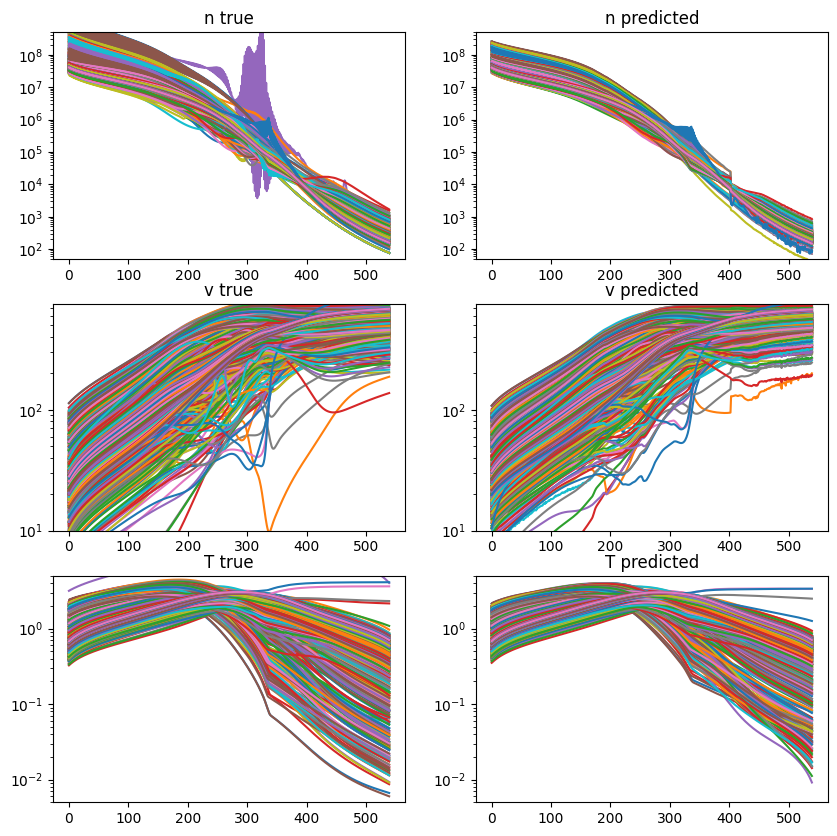

In [90]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

output_names = ['n', 'v', 'T']
lims = [[50, 500000000], [10, 750], [0.005, 5]]

for i in range(3):
    axs[i, 0].plot(y_test[:, i, :].T)
    axs[i, 0].set_yscale('log')
    axs[i, 0].set_ylim(lims[i])
    axs[i, 1].plot(y_pred[:, i, :].T)
    axs[i, 1].set_yscale('log')
    axs[i, 1].set_ylim(lims[i])
    
    axs[i, 0].set_title(f'{output_names[i]} true')
    axs[i, 1].set_title(f'{output_names[i]} predicted')
plt.show()


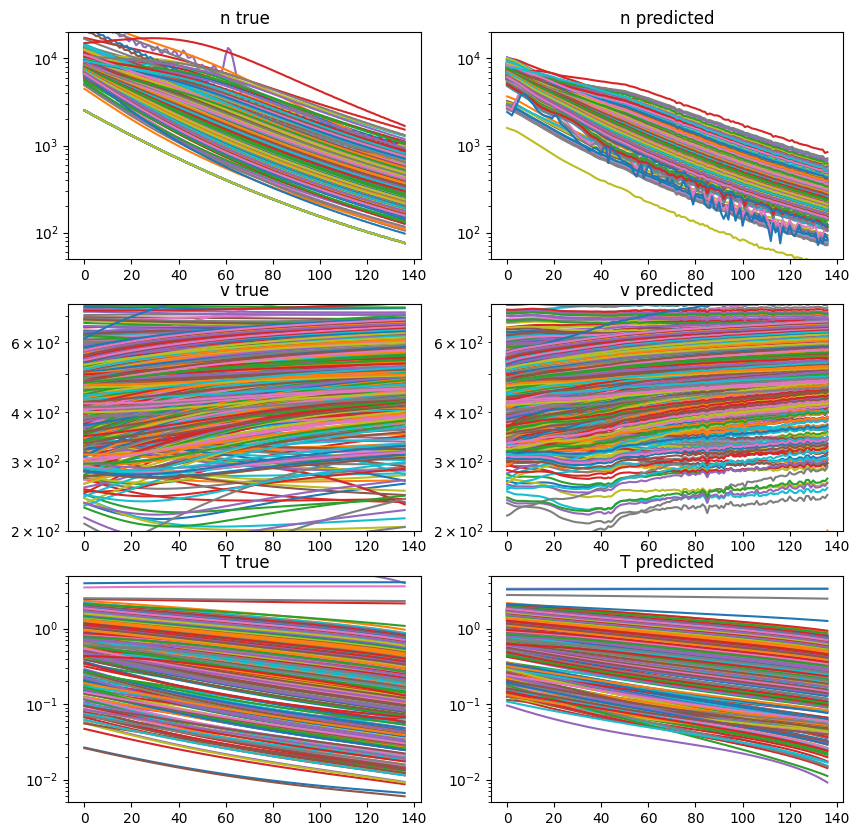

In [91]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

output_names = ['n', 'v', 'T']
lims = [[50, 20000], [200, 750], [0.005, 5]]

for i in range(3):
    axs[i, 0].plot(y_test[:, i, 403:].T)
    axs[i, 0].set_yscale('log')
    axs[i, 0].set_ylim(lims[i])
    axs[i, 1].plot(y_pred[:, i, 403:].T)
    axs[i, 1].set_yscale('log')
    axs[i, 1].set_ylim(lims[i])
    
    axs[i, 0].set_title(f'{output_names[i]} true')
    axs[i, 1].set_title(f'{output_names[i]} predicted')
plt.show()


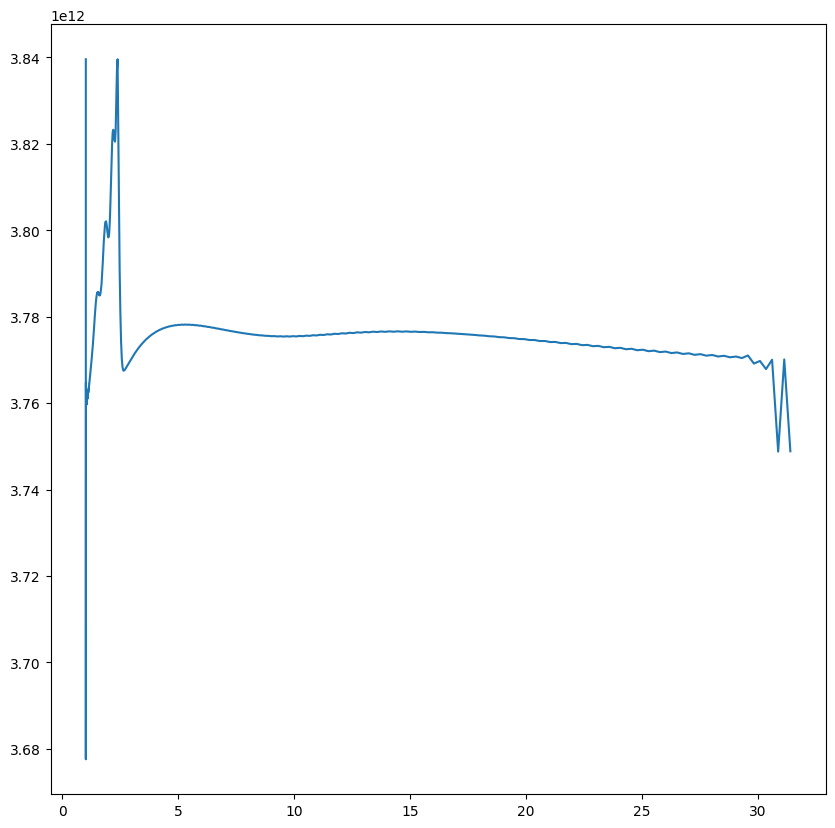

In [33]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

B_unnormalized = X_test_normalized[:lim, 2, :] * diff_inputs[2] + min_values_inputs[2]

n_exp = torch.exp(y_test[:lim, 0, :]) * diff_outputs[0] + min_values_outputs[0]
v_unnormalized = y_test[:lim, 1, :] * diff_outputs[1] + min_values_outputs[1]

nvB = (n_exp * v_unnormalized) / B_unnormalized

r_unnormalized = X_test_normalized[:, 0, :] * diff_inputs[0] + min_values_inputs[0]

plt.plot(r_unnormalized[0, :].T, nvB[0, :].T)
plt.show()

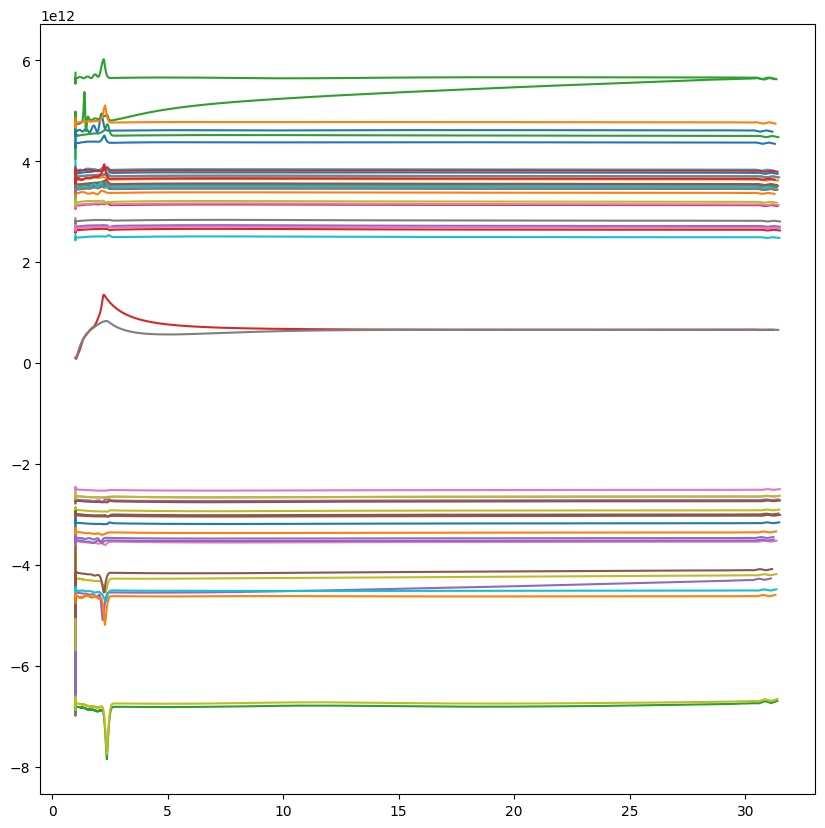

In [35]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

B_unnormalized = X_test_normalized[:lim, 2, :] * diff_inputs[2] + min_values_inputs[2]

n_exp = torch.exp(y_test[:lim, 0, :]) * diff_outputs[0] + min_values_outputs[0]
v_unnormalized = y_test[:lim, 1, :] * diff_outputs[1] + min_values_outputs[1]

nvB = (n_exp * v_unnormalized) / B_unnormalized

r_unnormalized = X_test_normalized[:lim, 0, :] * diff_inputs[0] + min_values_inputs[0]

plt.plot(r_unnormalized[:, :].T, nvB[:, :].T)
plt.show()

In [53]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

B_unnormalized = X_test_normalized[:lim, 2, :] * diff_inputs[2] + min_values_inputs[2]

n_exp = torch.exp(torch.Tensor(y_pred[:lim, 0, :])) * diff_outputs[0] + min_values_outputs[0]
v_unnormalized = torch.Tensor(y_pred[:lim, 1, :]) * diff_outputs[1] + min_values_outputs[1]

nvB = (n_exp * v_unnormalized) / B_unnormalized

r_unnormalized = X_test_normalized[:lim, 0, :] * diff_inputs[0] + min_values_inputs[0]

plt.plot(r_unnormalized[:, :].T, nvB[:, :].T)
plt.show()

c:\Users\nrtc\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_base.py:2957: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
c:\Users\nrtc\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\transforms.py:383: RuntimeWarning: overflow encountered in double_scalars
  return (x0, y0, x1 - x0, y1 - y0)


IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 1000x1000 with 1 Axes>

In [31]:
# loss on test set
model.eval()
test_loss = 0
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        y_pred = model(x)
        # denormalize y_pred and y
        loss = criterion(x, y_pred, y)
        test_loss += loss.item()
    test_loss /= len(test_loader)
    print(f'Test loss: {test_loss}')

Test loss: 0.036201712985571344


3 hidden layers

48 nodes

ReLU

dropout 0.2 em todas